In [1]:
import pandas as pd
import numpy as np
import tqdm
import torch

# Pre processing

In [2]:
import torch
from torch_geometric.data import Data, DataLoader
import os
import os.path as osp
import math
import argparse
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from graph_data import GraphDataset

gdata = GraphDataset(root='/anomalyvol/data/graph100particles',n_particles=100)

input_dim = 4
latent_dim = 32
fulllen = len(gdata)
tv_frac = 0.10
tv_num = math.ceil(fulllen*tv_frac)
splits = np.cumsum([fulllen-2*tv_num,tv_num,tv_num])
batch_size = 32
n_epochs = 20
lr = 0.001
patience = 10
device = 'cuda:0'
model_fname = 'EdgeNetPool'

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric.transforms as T
from torch_geometric.nn import EdgeConv, global_mean_pool

class EdgeNetPool(nn.Module):
    def __init__(self, input_dim=4, latent_dim=32, n_particles=100, aggr='mean'):
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.n_particles = n_particles
        self.aggr = aggr
        super(EdgeNetPool, self).__init__()
        encoder_nn = nn.Sequential(nn.Linear(2*(self.input_dim), 64),
                                   nn.ReLU(),
                                   nn.Linear(64, self.latent_dim),
                                   nn.ReLU(),
        )
        
        self.decoder = nn.Sequential(nn.Linear(self.latent_dim, 128),
                                   nn.ReLU(),
                                   nn.Linear(128, self.n_particles*self.input_dim)
        )
        
        self.batchnorm = nn.BatchNorm1d(input_dim)

        self.encoder = EdgeConv(nn=encoder_nn,aggr=aggr)

    def forward(self, data):
        data.x = self.batchnorm(data.x)
        data.x = self.encoder(data.x, data.edge_index)
        data.u = global_mean_pool(data.x, data.batch)
        data.x = self.decoder(data.u)
        data.x = torch.reshape(data.x, (-1, self.input_dim))
        return data.x

In [4]:
model = EdgeNetPool(input_dim=input_dim, latent_dim=latent_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = lr)

In [5]:
train_dataset = GraphDataset(root='/anomalyvol/data/graph100particles',n_particles=100,start=0,stop=splits[0])
valid_dataset = GraphDataset(root='/anomalyvol/data/graph100particles',n_particles=100,start=splits[1],stop=splits[2])
test_dataset = GraphDataset(root='/anomalyvol/data/graph100particles',n_particles=100,start=splits[0 ],stop=splits[1])

train_loader = DataLoader(train_dataset, batch_size=batch_size, pin_memory=True, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, pin_memory=True, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, pin_memory=True, shuffle=False)

train_samples = len(train_dataset)
valid_samples = len(valid_dataset)
test_samples = len(test_dataset)

print(train_samples)
print(valid_samples)
print(test_samples)
print(train_dataset[0])

24043
2405
2405
Data(edge_index=[2, 420], x=[100, 4], y=[100, 4])


In [6]:
@torch.no_grad()
def test(model,loader,total,batch_size):
    model.eval()
    
    mse = nn.MSELoss(reduction='mean')

    sum_loss = 0.
    t = tqdm.tqdm(enumerate(loader),total=total/batch_size)
    for i,data in t:
        data = data.to(device)
        batch_output = model(data)
        batch_loss_item = mse(batch_output, data.y).item()
        sum_loss += batch_loss_item
        t.set_description("loss = %.5f" % (batch_loss_item))
        t.refresh() # to show immediately the update

    return sum_loss/(i+1)

def train(model, optimizer, loader, total, batch_size):
    model.train()
    
    mse = nn.MSELoss(reduction='mean')

    sum_loss = 0.
    t = tqdm.tqdm(enumerate(loader),total=total/batch_size)
    for i,data in t:
        data = data.to(device)
        optimizer.zero_grad()
        batch_output = model(data)
        batch_loss = mse(batch_output, data.y)
        batch_loss.backward()
        batch_loss_item = batch_loss.item()
        t.set_description("loss = %.5f" % batch_loss_item)
        t.refresh() # to show immediately the update
        sum_loss += batch_loss_item
        optimizer.step()
    
    return sum_loss/(i+1)

In [7]:
modpath = osp.join('/anomalyvol/models/gnn/',model_fname+'.best.pth')
model.load_state_dict(torch.load(modpath))

<All keys matched successfully>

In [8]:
stale_epochs = 0
best_valid_loss = 99999
for epoch in range(0, n_epochs):
    loss = train(model, optimizer, train_loader, train_samples, batch_size)
    valid_loss = test(model, valid_loader, valid_samples, batch_size)
    print('Epoch: {:02d}, Training Loss:   {:.4f}'.format(epoch, loss))
    print('               Validation Loss: {:.4f}'.format(valid_loss))

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        modpath = osp.join('/anomalyvol/models/gnn/',model_fname+'.best.pth')
        print('New best model saved to:',modpath)
        torch.save(model.state_dict(),modpath)
        stale_epochs = 0
    else:
        print('Stale epoch')
        stale_epochs += 1
    if stale_epochs >= patience:
        print('Early stopping after %i stale epochs'%patience)
        break

loss = 855.82214: : 752it [30:20,  2.42s/it]                              
loss = 794.42181: : 76it [00:15,  4.91it/s]                             


Epoch: 00, Training Loss:   1755.0545
               Validation Loss: 1728.0057
New best model saved to: /anomalyvol/models/gnn/EdgeNetPool.best.pth


loss = 1305.38599: : 752it [07:44,  1.62it/s]                             
loss = 797.61145: : 76it [00:18,  4.13it/s]                             
  0%|          | 0/751.34375 [00:00<?, ?it/s]

Epoch: 01, Training Loss:   1753.3090
               Validation Loss: 1783.6992
Stale epoch


loss = 2138.02100: : 752it [07:35,  1.65it/s]                             
loss = 796.62927: : 76it [00:18,  4.02it/s]                             
  0%|          | 0/751.34375 [00:00<?, ?it/s]

Epoch: 02, Training Loss:   1754.0164
               Validation Loss: 1779.5909
Stale epoch


loss = 2301.19678: : 752it [07:42,  1.63it/s]                             
loss = 797.88849: : 76it [00:16,  4.59it/s]                              
  0%|          | 0/751.34375 [00:00<?, ?it/s]

Epoch: 03, Training Loss:   1753.9449
               Validation Loss: 2163.0994
Stale epoch


loss = 1296.62598: : 752it [07:41,  1.63it/s]                             
loss = 795.84290: : 76it [00:18,  4.04it/s]                             


Epoch: 04, Training Loss:   1752.4041
               Validation Loss: 1727.9990
New best model saved to: /anomalyvol/models/gnn/EdgeNetPool.best.pth


loss = 989.75793: : 752it [14:41,  1.17s/it]                              
loss = 794.03540: : 76it [00:18,  4.21it/s]                              
  0%|          | 0/751.34375 [00:00<?, ?it/s]

Epoch: 05, Training Loss:   1750.9271
               Validation Loss: 1902.9135
Stale epoch


loss = 728.19263: : 752it [07:37,  1.64it/s]                              
loss = 798.93256: : 76it [00:19,  3.98it/s]                              
  0%|          | 0/751.34375 [00:00<?, ?it/s]

Epoch: 06, Training Loss:   1749.6960
               Validation Loss: 2033.7063
Stale epoch


loss = 2793.74805: : 752it [07:31,  1.67it/s]                             
loss = 796.10669: : 76it [00:18,  4.09it/s]                              
  0%|          | 0/751.34375 [00:00<?, ?it/s]

Epoch: 07, Training Loss:   1751.3120
               Validation Loss: 2028.0172
Stale epoch


loss = 1384.45203: : 752it [07:42,  1.63it/s]                             
loss = 794.39874: : 76it [00:18,  4.13it/s]                               
  0%|          | 0/751.34375 [00:00<?, ?it/s]

Epoch: 08, Training Loss:   1749.4996
               Validation Loss: 3093.9390
Stale epoch


loss = 3787.98877: : 752it [07:36,  1.65it/s]                             
loss = 797.61743: : 76it [00:18,  4.12it/s]                               
  0%|          | 0/751.34375 [00:00<?, ?it/s]

Epoch: 09, Training Loss:   1751.2610
               Validation Loss: 3839.0492
Stale epoch


loss = 808.44794: : 752it [10:53,  1.15it/s]                              
loss = 789.76263: : 76it [00:29,  2.61it/s]                               
  0%|          | 0/751.34375 [00:00<?, ?it/s]

Epoch: 10, Training Loss:   1747.5511
               Validation Loss: 4184.6288
Stale epoch


loss = 1831.18384: : 752it [09:32,  1.31it/s]                             
loss = 796.63690: : 76it [00:18,  4.07it/s]                               
  0%|          | 0/751.34375 [00:00<?, ?it/s]

Epoch: 11, Training Loss:   1747.7602
               Validation Loss: 5287.3608
Stale epoch


loss = 796.60840: : 752it [07:36,  1.65it/s]                              
loss = 789.47205: : 76it [00:16,  4.49it/s]                               
  0%|          | 0/751.34375 [00:00<?, ?it/s]

Epoch: 12, Training Loss:   1746.8201
               Validation Loss: 6235.3052
Stale epoch


loss = 2259.34326: : 752it [07:37,  1.64it/s]                             
loss = 789.62201: : 76it [00:18,  4.20it/s]                               
  0%|          | 0/751.34375 [00:00<?, ?it/s]

Epoch: 13, Training Loss:   1747.0419
               Validation Loss: 3578.1989
Stale epoch


loss = 1683.34656: : 752it [07:18,  1.71it/s]                             
loss = 790.24103: : 76it [00:19,  3.99it/s]                               

Epoch: 14, Training Loss:   1745.3578
               Validation Loss: 3961.5174
Stale epoch
Early stopping after 10 stale epochs


In [9]:
model.load_state_dict(torch.load(modpath))
input_x = []
output_x = []

t = tqdm.tqdm(enumerate(test_loader),total=test_samples/batch_size)
for i, data in t:
    data.to(device)
    input_x.append(data.x.cpu().numpy())
    output_x.append(model(data).cpu().detach().numpy())

76it [00:19,  3.93it/s]                              


In [11]:
def in_out_diff_append(diff, output, inputs, i, ft_idx): # helper for appending 3 lists
    diff.append(((output_x[i][:,ft_idx]-input_x[i][:,ft_idx])/input_x[i][:,ft_idx]).flatten())
    output.append(output_x[i][:,ft_idx].flatten())
    inputs.append(input_x[i][:,ft_idx].flatten())

def in_out_diff_concat(diff, output, inputs):
    diff = np.concatenate(diff)
    output = np.concatenate(output)
    inputs = np.concatenate(inputs)
    return [diff, output, inputs]

def make_hists(diff, output, inputs, bin1):
    plt.figure()
    plt.hist(inputs, bins=bin1,alpha=0.5)
    plt.hist(output, bins=bin1,alpha=0.5)
    plt.show()

    plt.figure()
    plt.hist(diff, bins=np.linspace(-5, 5, 101))
    plt.show()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  


px


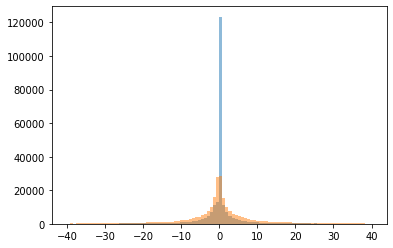

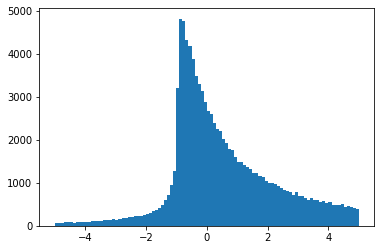

py


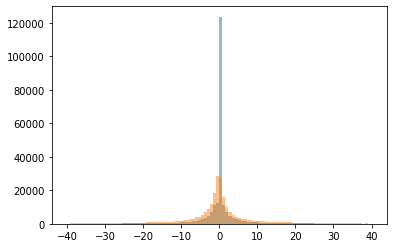

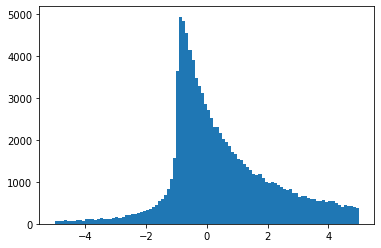

pz


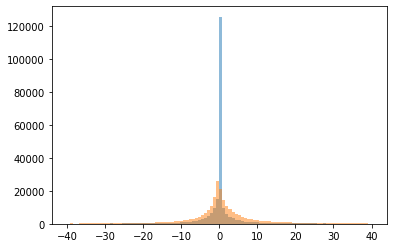

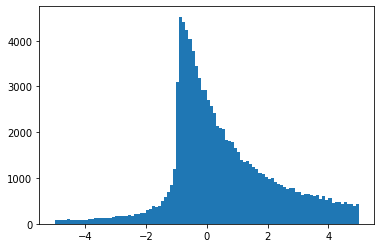

e


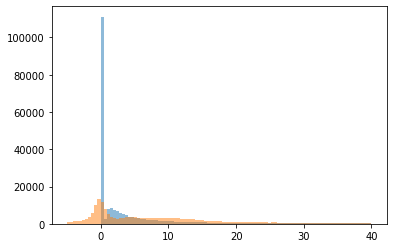

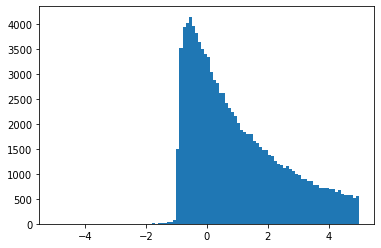

In [12]:
diff_px = []
output_px = []
input_px = []
diff_py = []
output_py = []
input_py = []
diff_pz = []
output_pz = []
input_pz = []
diff_e = []
output_e = []
input_e = []

# get output in readable format
for i in range(len(input_x)):
    # px
    in_out_diff_append(diff_px, output_px, input_px, i, 0)
    in_out_diff_append(diff_py, output_py, input_py, i, 1)
    in_out_diff_append(diff_pz, output_pz, input_pz, i, 2)
    in_out_diff_append(diff_e, output_e, input_e, i, 3)

# remove extra brackets
diff_px, output_px, input_px = in_out_diff_concat(diff_px, output_px, input_px)
diff_py, output_py, input_py = in_out_diff_concat(diff_py, output_py, input_py)
diff_pz, output_pz, input_pz = in_out_diff_concat(diff_pz, output_pz, input_pz)
diff_e, output_e, input_e = in_out_diff_concat(diff_e, output_e, input_e)

print("px")
bins = np.linspace(-40, 40, 101)
make_hists(diff_px, output_px, input_px, bins)

print("py")
make_hists(diff_py, output_py, input_py, bins)

print("pz")
make_hists(diff_pz, output_pz, input_pz, bins)

print("e")
bins = np.linspace(-5, 40, 101)
make_hists(diff_e, output_e, input_e, bins)